# Solvent-Environment Dependence of the Excess Chemical Potential and its Computation Scheme Formulated Though Error Minimization: <br>*Determination of octanol-water partitioning free energy*
Stefan Hervø-Hansen<sup>a</sup>, Kazuya Okita<sup>a</sup>, Kento Kasahara<sup>a</sup>, and Nobuyuki Matubayasi<sup>a,</sup><br><br>
<sup>a</sup> Division of Chemical Engineering, Graduate School of Engineering Science, Osaka University, Toyonaka, Osaka 560-8531, Japan.<br>
<sup></sup> Correspondence may be addressed to: stefan@cheng.es.osaka-u.ac.jp and nobuyuki@cheng.es.osaka-u.ac.jp.


## Part 1: Usage of Original BAR Method to Establish Baseline

## Import of Python Modules & Auxiliary Functions

In [1]:
import sys
import os
import numpy as np
import openmm as mm
import shutil
import matplotlib as mpl
from uncertainties import unumpy, ufloat, umath
from multiprocessing import Pool
import mdtraj as md
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#e69f00", "#56b4e9", "#009e73"])
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'
mpl.rcParams["text.usetex"] = True
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

from Auxiliary import fessa
plt.set_cmap('fessa')

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#e69f00", "#56b4e9", "#009e73"])

kJ_to_kcal = 0.239

homedir = !pwd
homedir = homedir[0]
workdir = '/home/users/eau/Octanol-Water_partitioning' # RCCS
print(homedir)

/data/group1/z44785r/Octanol-Water_partitioning


<Figure size 640x480 with 0 Axes>

In [2]:
def get_2D_PMF(xall, yall, weights=None, nbins=50, avoid_zero_count=True, minener_zero=True, kT=1.0, ranges=None):
    """Free energy plot given 2D scattered data.
Builds a 2D-histogram of the given data points and plots -log(p) where p is
the probability computed from the histogram count.
Parameters
----------
xall : ndarray(T)
    sample x-coordinates
yall : ndarray(T)
    sample y-coordinates
weights : ndarray(T), default = None
    sample weights. By default all samples have the same weight
nbins : int, default=100
    number of histogram bins used in each dimension
avoid_zero_count : bool, default=True
    avoid zero counts by lifting all histogram elements to the minimum value
    before computing the free energy. If False, zero histogram counts will
    yield NaNs in the free energy which and thus regions that are not plotted.
minener_zero : bool, default=True
    Shifts the energy minimum to zero. If false, will not shift at all.
kT : float, default=1.0
    The value of kT in the desired energy unit. By default, will compute
    energies in kT (setting 1.0). If you want to measure the energy in
    kJ/mol at 298 K, use kT=2.479 and change the cbar_label accordingly.
ranges : tuple
    The extend the 2d histogram should be compute. The tuple should 
    have the form ((xmin, xmax), (ymin, ymax)).
Returns
-------
(x,y,F)
"""
    # histogram
    z, xedge, yedge = np.histogram2d(xall, yall, bins=nbins, weights=weights, range=ranges)
    x = 0.5*(xedge[:-1] + xedge[1:])
    y = 0.5*(yedge[:-1] + yedge[1:])
    # avoid zeros
    if avoid_zero_count:
        zmin_nonzero = np.min(z[np.where(z > 0)])
        z = np.maximum(z, zmin_nonzero)
    # compute free energies
    F = -kT * np.log(z)
    if minener_zero:
        F -= np.min(F)

    return (x,y,F.T)

## Simulation Settings

In [3]:
# Alchemical pathway
lambdas = {
    1: {'sterics': 0.0, 'electrostatics': 0.0},
    2: {'sterics': 0.1, 'electrostatics': 0.0},
    3: {'sterics': 0.2, 'electrostatics': 0.0},
    4: {'sterics': 0.3, 'electrostatics': 0.0},
    5: {'sterics': 0.4, 'electrostatics': 0.0},
    6: {'sterics': 0.5, 'electrostatics': 0.0},
    7: {'sterics': 0.6, 'electrostatics': 0.0},
    8: {'sterics': 0.7, 'electrostatics': 0.0},
    9: {'sterics': 0.8, 'electrostatics': 0.0},
   10: {'sterics': 0.9, 'electrostatics': 0.0},
   11: {'sterics': 1.0, 'electrostatics': 0.0},
   12: {'sterics': 1.0, 'electrostatics': 0.2},
   13: {'sterics': 1.0, 'electrostatics': 0.4},
   14: {'sterics': 1.0, 'electrostatics': 0.6},
   15: {'sterics': 1.0, 'electrostatics': 0.8},
   16: {'sterics': 1.0, 'electrostatics': 1.0},
}


## SIMULATION SETTINGS ##

# Total simulation time = outFreq x NumAlchemicalSnapshots x dt             [500 x 50000 x 2 fs = 50 ns]
NumAlchemicalSnapshots = 50000 # Number of alchemical energies computed
outFreq = 500 # Output frequence

# Generate files for running MD simulations?
PERFORM_SOLUTE_TO_WATER_SIMULATIONS = False
PERFORM_SOLUTE_TO_OCTANOL_SIMULATIONS = False

## Step 1: 1-hexanol from Gas Phase to Water
### Generation of initial configuration and topology

In [4]:
%cd -q $homedir

if PERFORM_SOLUTE_TO_WATER_SIMULATIONS:
    for l in lambdas:
        %cd -q $homedir/Simulations/BAR/Water/$l
        %mkdir min
        %cp $homedir/PDB_files/Hexanol_in_water.gro min/init.gro
        %cp $homedir/Force_fields/OPLS-AA-1.14_CM1A-LBCC_GROMACS/Hexanol_in_water.top .

### Generation of mdp Files

In [5]:
%cd -q $homedir

GROMACS_mdp_min="""
; Run control
integrator               = steep 
nsteps                   = 5000
; EM criteria and other stuff
emtol                    = 100
emstep                   = 0.01
niter                    = 20
nbfgscorr                = 10
; Output control
nstlog                   = 1
nstenergy                = 1
; Neighborsearching and short-range nonbonded interactions
cutoff-scheme            = verlet
nstlist                  = 1
pbc                      = xyz
rlist                    = 1.2
; Electrostatics
coulombtype              = PME
rcoulomb                 = 1.2
; van der Waals
vdwtype = switch
rvdw            = 1.2
rvdw_switch = 1.0
DispCorr        = No
; Spacing for the PME/PPPM FFT grid
fourierspacing           = 0.12
; EWALD/PME/PPPM parameters
pme_order                = 6
ewald_rtol               = 1e-06
epsilon_surface          = 0
; Temperature and pressure coupling are off during EM
tcoupl                   = no
pcoupl                   = no
; Bond parameters
constraint_algorithm    = lincs
constraints             = h-bonds
continuation            = no
define = -DFLEXIBLE 

; Free energy variables
free-energy                 = yes
nstdhdl                     = 500
couple-moltype              = HEX
couple-lambda0              = none
couple-lambda1              = vdw-q
couple-intramol             = no
init-lambda-state           = {default_lambda}
delta-lambda                = 0
vdw_lambdas                 = 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 1.0 1.0 1.0 1.0 1.0
coul_lambdas                = 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.4 0.6 0.8 1.0
calc-lambda-neighbors       = 1
dhdl-print-energy           = no
sc-function                 = beutler
sc-alpha                    = 0.5
sc-power                    = 1
sc-r-power                  = 6
sc-sigma                    = 0.3
sc-coul                     = no
sc-gapsys-scale-linpoint-lj = 0.85
sc-gapsys-scale-linpoint-q  = 0.3
sc-gapsys-sigma-lj          = 0.3
separate-dhdl-file          = no
dhdl-derivatives            = no
dh_hist_size                = 0
dh_hist_spacing             = 0.1
"""

GROMACS_mdp_eq="""
; RUN CONTROL PARAMETERS
; Run parameters
integrator  = sd
dt          = 0.002
tinit       = 0
nsteps      = 5000000   ; 10 ns
; Output parameters
nstxout-compressed  = 500  ; 1 ps
nstenergy           = 500  ; 1 ps
; Bond parameters
constraint_algorithm    = lincs
constraints             = h-bonds
continuation            = no
; Single-range cutoff scheme
cutoff-scheme   = Verlet
nstlist         = 20 
;verlet-buffer-tolerance = 0.0001
rcoulomb        = 1.2
; van der Waals
vdwtype = switch
rvdw            = 1.2
rvdw_switch = 1.0
DispCorr        = No
; PME electrostatics parameters
coulombtype     = PME
fourierspacing  = 0.12
pme_order       = 4
ewald_rtol      = 1e-5
; Temperature coupling is on in two groups
tc-grps         = system
tau-t           = 1.0
ref-t           = 298.15
; Pressure coupling is off
Pcoupl          = no
; Generate velocities is off
gen_vel     = yes 
; Periodic boundary conditions are on in all directions
pbc     = xyz

; Free energy variables
free-energy                 = yes
nstdhdl                     = 500
couple-moltype              = HEX
couple-lambda0              = none
couple-lambda1              = vdw-q
couple-intramol             = no
init-lambda-state           = {default_lambda}
delta-lambda                = 0
vdw_lambdas                 = 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 1.0 1.0 1.0 1.0 1.0
coul_lambdas                = 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.4 0.6 0.8 1.0
calc-lambda-neighbors       = 1
dhdl-print-energy           = no
sc-function                 = beutler
sc-alpha                    = 0.5
sc-power                    = 1
sc-r-power                  = 6
sc-sigma                    = 0.3
sc-coul                     = no
sc-gapsys-scale-linpoint-lj = 0.85
sc-gapsys-scale-linpoint-q  = 0.3
sc-gapsys-sigma-lj          = 0.3
separate-dhdl-file          = no
dhdl-derivatives            = no
dh_hist_size                = 0
dh_hist_spacing             = 0.1
"""

GROMACS_mdp_production="""
; RUN CONTROL PARAMETERS
; Run parameters
integrator  = sd
dt          = 0.002
tinit       = 0
nsteps      = 25000000   ; 50 ns
; Output parameters
nstxout-compressed  = 500  ; 1 ps
nstenergy           = 500  ; 1 ps
; Bond parameters
constraint_algorithm    = lincs
constraints             = h-bonds
continuation            = yes
; Single-range cutoff scheme
cutoff-scheme   = Verlet
nstlist         = 20 
;verlet-buffer-tolerance = 0.0001
rcoulomb        = 1.2
; van der Waals
vdwtype = switch
rvdw            = 1.2
rvdw_switch = 1.0
DispCorr        = No
; PME electrostatics parameters
coulombtype     = PME
fourierspacing  = 0.12
pme_order       = 4
ewald_rtol      = 1e-5
; Temperature coupling is on in two groups
tc-grps         = system
tau-t           = 1.0
ref-t           = 298.15
; Pressure coupling is off
Pcoupl          = no
; Generate velocities is off
gen_vel     = no 
; Periodic boundary conditions are on in all directions
pbc     = xyz

; Free energy variables
free-energy                 = yes
nstdhdl                     = 500
couple-moltype              = HEX
couple-lambda0              = none
couple-lambda1              = vdw-q
couple-intramol             = no
init-lambda-state           = {default_lambda}
delta-lambda                = 0
vdw_lambdas                 = 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 1.0 1.0 1.0 1.0 1.0
coul_lambdas                = 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.4 0.6 0.8 1.0
calc-lambda-neighbors       = 1
dhdl-print-energy           = no
sc-function                 = beutler
sc-alpha                    = 0.5
sc-power                    = 1
sc-r-power                  = 6
sc-sigma                    = 0.3
sc-coul                     = no
sc-gapsys-scale-linpoint-lj = 0.85
sc-gapsys-scale-linpoint-q  = 0.3
sc-gapsys-sigma-lj          = 0.3
separate-dhdl-file          = no
dhdl-derivatives            = no
dh_hist_size                = 0
dh_hist_spacing             = 0.1
"""          

N_simulations = 0
if PERFORM_SOLUTE_TO_WATER_SIMULATIONS:
    for l in lambdas:
        l = '{0:.0f}'.format(l)
        %cd -q $homedir/Simulations/BAR/Water/$l
        
        with open('min/min.mdp', 'w') as f:
            f.write(GROMACS_mdp_min.format(default_lambda=str(int(l)-1)))
        f.close()
        
        %mkdir eq
        with open('eq/eq.mdp', 'w') as f:
            f.write(GROMACS_mdp_eq.format(default_lambda=str(int(l)-1)))
        f.close()
        
        with open('BAR.mdp', 'w') as f:
            f.write(GROMACS_mdp_production.format(default_lambda=str(int(l)-1)))
        f.close()
        
        print('Wrote mdp files to '+os.getcwd())
        N_simulations+=1
        
    print('Simulations about to be submitted: {}'.format(N_simulations))

### Submit Script

In [6]:
%cd -q $homedir

submit_script="""#!/bin/bash
## RCCS
#PBS -l select=1:ncpus=16:mpiprocs=1:ompthreads=16:jobtype=gpu:ngpus=1
#PBS -l walltime=24:00:00
#PBS -N Water_{lambda_value}
#PBS -e run.err
#PBS -o run.out

cd {path}

source ~/.bashrc
source ~/.bash_profile

module purge
module load gromacs/2024.2-CUDA

# Minimization
cd min
gmx grompp -f min.mdp -p ../Hexanol_in_water.top -c init.gro -o min.tpr
gmx mdrun -deffnm min -ntmpi 1

# Equilibration
cd ../eq
gmx grompp -f eq.mdp -p ../Hexanol_in_water.top -c ../min/min.gro -o eq.tpr
gmx mdrun -deffnm eq -ntmpi 1

# Production
cd ..
gmx grompp -f BAR.mdp -p Hexanol_in_water.top -c eq/eq.gro -o BAR.tpr
gmx mdrun -deffnm BAR -ntmpi 1
"""

master_submit_script="""#!/bin/bash
read -p "Will submit {N_simulations} simulations. Do you want to proceed? (yes/no) " yn

case $yn in 
    yes ) echo submitting...;;
    no ) echo exiting...;
         exit;;
    * ) echo invalid response;
        exit 1;;
esac

"""
if PERFORM_SOLUTE_TO_WATER_SIMULATIONS:
    with open('Simulations/BAR/Water/master_water.sh', 'w') as ff:
        ff.write(master_submit_script.format(N_simulations=N_simulations))
    
        for l in lambdas:
            l = '{0:.0f}'.format(l)
            %cd -q $homedir/Simulations/BAR/Water/$l
                    
            simpath = os.getcwd()
            simpath = simpath.split(sep='Octanol-Water_partitioning')[1]
            simpath = workdir+simpath
            with open('submit.pbs', 'w') as f:
                f.write(submit_script.format(path=simpath, lambda_value=l))
            f.close()
            s =  'cd {}\njsub submit.pbs\n\n'.format(simpath) # RCCS
            ff.write(s)
                    
    ff.close()

## Step 2: 1-hexanol from Gas Phase to Octanol
### Generation of Initial Configuration and Topology

In [7]:
%cd -q $homedir

if PERFORM_SOLUTE_TO_OCTANOL_SIMULATIONS:
    for l in lambdas:
        %cd -q $homedir/Simulations/BAR/1-Octanol/$l
        %mkdir min
        %cp $homedir/PDB_files/Hexanol_in_octanol.gro min/init.gro
        %cp $homedir/Force_fields/OPLS-AA-1.14_CM1A-LBCC_GROMACS/Hexanol_in_octanol.top .

### Generation of mdp Files

In [8]:
%cd -q $homedir

GROMACS_mdp_min="""
; Run control
integrator               = steep 
nsteps                   = 5000
; EM criteria and other stuff
emtol                    = 100
emstep                   = 0.01
niter                    = 20
nbfgscorr                = 10
; Output control
nstlog                   = 1
nstenergy                = 1
; Neighborsearching and short-range nonbonded interactions
cutoff-scheme            = verlet
nstlist                  = 1
pbc                      = xyz
rlist                    = 1.2
; Electrostatics
coulombtype              = PME
rcoulomb                 = 1.2
; van der Waals
vdwtype = switch
rvdw            = 1.2
rvdw_switch = 1.0
DispCorr        = No
; Spacing for the PME/PPPM FFT grid
fourierspacing           = 0.12
; EWALD/PME/PPPM parameters
pme_order                = 6
ewald_rtol               = 1e-06
epsilon_surface          = 0
; Temperature and pressure coupling are off during EM
tcoupl                   = no
pcoupl                   = no
; Bond parameters
constraint_algorithm    = lincs
constraints             = h-bonds
continuation            = no

; Free energy variables
free-energy                 = yes
nstdhdl                     = 500
couple-moltype              = HEX
couple-lambda0              = none
couple-lambda1              = vdw-q
couple-intramol             = no
init-lambda-state           = {default_lambda}
delta-lambda                = 0
vdw_lambdas                 = 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 1.0 1.0 1.0 1.0 1.0
coul_lambdas                = 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.4 0.6 0.8 1.0
calc-lambda-neighbors       = 1
dhdl-print-energy           = no
sc-function                 = beutler
sc-alpha                    = 0.5
sc-power                    = 1
sc-r-power                  = 6
sc-sigma                    = 0.3
sc-coul                     = no
sc-gapsys-scale-linpoint-lj = 0.85
sc-gapsys-scale-linpoint-q  = 0.3
sc-gapsys-sigma-lj          = 0.3
separate-dhdl-file          = no
dhdl-derivatives            = no
dh_hist_size                = 0
dh_hist_spacing             = 0.1
"""

GROMACS_mdp_eq="""
; RUN CONTROL PARAMETERS
; Run parameters
integrator  = sd
dt          = 0.002
tinit       = 0
nsteps      = 5000000   ; 10 ns
; Output parameters
nstxout-compressed  = 500  ; 1 ps
nstenergy           = 500  ; 1 ps
; Bond parameters
constraint_algorithm    = lincs
constraints             = h-bonds
continuation            = no
; Single-range cutoff scheme
cutoff-scheme   = Verlet
nstlist         = 20 
;verlet-buffer-tolerance = 0.0001
rcoulomb        = 1.2
; van der Waals
vdwtype = switch
rvdw            = 1.2
rvdw_switch = 1.0
DispCorr        = No
; PME electrostatics parameters
coulombtype     = PME
fourierspacing  = 0.12
pme_order       = 4
ewald_rtol      = 1e-5
; Temperature coupling is on in two groups
tc-grps         = system
tau-t           = 1.0
ref-t           = 298.15
; Pressure coupling is off
Pcoupl          = no
; Generate velocities is off
gen_vel     = yes 
; Periodic boundary conditions are on in all directions
pbc     = xyz

; Free energy variables
free-energy                 = yes
nstdhdl                     = 500
couple-moltype              = HEX
couple-lambda0              = none
couple-lambda1              = vdw-q
couple-intramol             = no
init-lambda-state           = {default_lambda}
delta-lambda                = 0
vdw_lambdas                 = 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 1.0 1.0 1.0 1.0 1.0
coul_lambdas                = 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.4 0.6 0.8 1.0
calc-lambda-neighbors       = 1
dhdl-print-energy           = no
sc-function                 = beutler
sc-alpha                    = 0.5
sc-power                    = 1
sc-r-power                  = 6
sc-sigma                    = 0.3
sc-coul                     = no
sc-gapsys-scale-linpoint-lj = 0.85
sc-gapsys-scale-linpoint-q  = 0.3
sc-gapsys-sigma-lj          = 0.3
separate-dhdl-file          = no
dhdl-derivatives            = no
dh_hist_size                = 0
dh_hist_spacing             = 0.1
"""

GROMACS_mdp_production="""
; RUN CONTROL PARAMETERS
; Run parameters
integrator  = sd
dt          = 0.002
tinit       = 0
nsteps      = 25000000   ; 50 ns
; Output parameters
nstxout-compressed  = 500  ; 1 ps
nstenergy           = 500  ; 1 ps
; Bond parameters
constraint_algorithm    = lincs
constraints             = h-bonds
continuation            = yes
; Single-range cutoff scheme
cutoff-scheme   = Verlet
nstlist         = 20 
;verlet-buffer-tolerance = 0.0001
rcoulomb        = 1.2
; van der Waals
vdwtype = switch
rvdw            = 1.2
rvdw_switch = 1.0
DispCorr        = No
; PME electrostatics parameters
coulombtype     = PME
fourierspacing  = 0.12
pme_order       = 4
ewald_rtol      = 1e-5
; Temperature coupling is on in two groups
tc-grps         = system
tau-t           = 1.0
ref-t           = 298.15
; Pressure coupling is off
Pcoupl          = no 
; Generate velocities is off
gen_vel     = no 
; Periodic boundary conditions are on in all directions
pbc     = xyz

; Free energy variables
free-energy                 = yes
nstdhdl                     = 500
couple-moltype              = HEX
couple-lambda0              = none
couple-lambda1              = vdw-q
couple-intramol             = no
init-lambda-state           = {default_lambda}
delta-lambda                = 0
vdw_lambdas                 = 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 1.0 1.0 1.0 1.0 1.0
coul_lambdas                = 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.4 0.6 0.8 1.0
calc-lambda-neighbors       = 1
dhdl-print-energy           = no
sc-function                 = beutler
sc-alpha                    = 0.5
sc-power                    = 1
sc-r-power                  = 6
sc-sigma                    = 0.3
sc-coul                     = no
sc-gapsys-scale-linpoint-lj = 0.85
sc-gapsys-scale-linpoint-q  = 0.3
sc-gapsys-sigma-lj          = 0.3
separate-dhdl-file          = no
dhdl-derivatives            = no
dh_hist_size                = 0
dh_hist_spacing             = 0.1
"""          

N_simulations = 0
if PERFORM_SOLUTE_TO_OCTANOL_SIMULATIONS:
    for l in lambdas:
        l = '{0:.0f}'.format(l)
        %cd -q $homedir/Simulations/BAR/1-Octanol/$l
        
        with open('min/min.mdp', 'w') as f:
            f.write(GROMACS_mdp_min.format(default_lambda=str(int(l)-1)))
        f.close()
        
        %mkdir eq
        with open('eq/eq.mdp', 'w') as f:
            f.write(GROMACS_mdp_eq.format(default_lambda=str(int(l)-1)))
        f.close()
        
        with open('BAR.mdp', 'w') as f:
            f.write(GROMACS_mdp_production.format(default_lambda=str(int(l)-1)))
        f.close()
        
        print('Wrote mdp files to '+os.getcwd())
        N_simulations+=1
        
    print('Simulations about to be submitted: {}'.format(N_simulations))

### Submit Script

In [9]:
%cd -q $homedir

submit_script="""#!/bin/bash
## RCCS
#PBS -l select=1:ncpus=16:mpiprocs=1:ompthreads=16:jobtype=gpu:ngpus=1
#PBS -l walltime=168:00:00
#PBS -N Octanol_{lambda_value}
#PBS -e run.err
#PBS -o run.out

cd {path}

source ~/.bashrc
source ~/.bash_profile

module purge
module load gromacs/2024.2-CUDA

# Minimization
cd min
gmx grompp -f min.mdp -p ../Hexanol_in_octanol.top -c init.gro -o min.tpr
gmx mdrun -deffnm min -ntmpi 1

# Equilibration
cd ../eq
gmx grompp -f eq.mdp -p ../Hexanol_in_octanol.top -c ../min/min.gro -o eq.tpr
gmx mdrun -deffnm eq -ntmpi 1

# Production
cd ..
gmx grompp -f BAR.mdp -p Hexanol_in_octanol.top -c eq/eq.gro -o BAR.tpr
gmx mdrun -deffnm BAR -ntmpi 1
"""

master_submit_script="""#!/bin/bash
read -p "Will submit {N_simulations} simulations. Do you want to proceed? (yes/no) " yn

case $yn in 
    yes ) echo submitting...;;
    no ) echo exiting...;
         exit;;
    * ) echo invalid response;
        exit 1;;
esac

"""
if PERFORM_SOLUTE_TO_OCTANOL_SIMULATIONS:
    with open('Simulations/BAR/1-Octanol/master_octanol.sh', 'w') as ff:
        ff.write(master_submit_script.format(N_simulations=N_simulations))
    
        for l in lambdas:
            l = '{0:.0f}'.format(l)
            %cd -q $homedir/Simulations/BAR/1-Octanol/$l
                    
            simpath = os.getcwd()
            simpath = simpath.split(sep='Octanol-Water_partitioning')[1]
            simpath = workdir+simpath
            with open('submit.pbs', 'w') as f:
                f.write(submit_script.format(path=simpath, lambda_value=l))
            f.close()
            s =  'cd {}\njsub submit.pbs\n\n'.format(simpath) # RCCS
            ff.write(s)
                    
    ff.close()

## Step 3: Determination of Octanol-Water Partitioning Free Energy and Partitioning Coefficient

In [10]:
%cd -q $homedir

with open('Simulations/BAR/Water/BAR_result/bar.out', 'r') as f:
    lines = f.readlines()
f.close()
dG_water = ufloat(float(lines[-2].split()[5]), float(lines[-2].split()[7])*1.96) * kJ_to_kcal # 95% error

with open('Simulations/BAR/1-Octanol/BAR_result/bar.out', 'r') as f:
    lines = f.readlines()
f.close()
dG_octanol = ufloat(float(lines[-2].split()[5]), float(lines[-2].split()[7])*1.96) * kJ_to_kcal # 95% error

print('Solvation free energy of hexanol into water: {:.2f} +/- {:.2f} kcal/mol'.format(dG_water.nominal_value, dG_water.std_dev))
print('Solvation free energy of hexanol into octanol: {:.2f} +/- {:.2f} kcal/mol'.format(dG_octanol.nominal_value, dG_octanol.std_dev))

ddG = dG_octanol - dG_water
print('Transfer free energy of hexanol from water to octanol: {:.2f} +/- {:.2f} kcal/mol'.format(ddG.nominal_value, ddG.std_dev))
RT = 0.5925 # kcal/mol assuming 298.15 Kelvin
logKow = -ddG/(np.log(10)*RT)
print('log(Kow): {:.2f} +/- {:.2f}'.format(logKow.nominal_value, logKow.std_dev))

Solvation free energy of hexanol into water: -3.79 +/- 0.02 kcal/mol
Solvation free energy of hexanol into octanol: -5.73 +/- 0.06 kcal/mol
Transfer free energy of hexanol from water to octanol: -1.94 +/- 0.06 kcal/mol
log(Kow): 1.42 +/- 0.04


## Step 4: Convergence of Solvation Free Energy of *n*-hexanol in Octanol and Water with Simulation Time

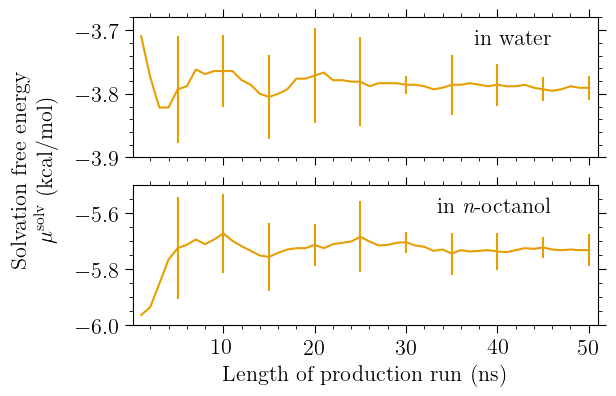

In [11]:
%cd -q $homedir

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6,4), sharex=True)

dG_water = np.zeros(50)
dG_water_err = np.zeros(50)
dG_octanol = np.zeros(50)
dG_octanol_err = np.zeros(50)

for i in range(50):
    # Water
    with open('Simulations/BAR/Water/BAR_result/bar_{}.out'.format((i+1)*1000), 'r') as f:
        lines = f.readlines()
    f.close()
    dG_water[i] = float(lines[-2].split()[5]) * kJ_to_kcal
    dG_water_err[i] = float(lines[-2].split()[7]) * kJ_to_kcal * 1.96 # 95% errors.

    # Octanol
    with open('Simulations/BAR/1-Octanol/BAR_result/bar_{}.out'.format((i+1)*1000), 'r') as f:
        lines = f.readlines()
    f.close()
    dG_octanol[i] = float(lines[-2].split()[5]) * kJ_to_kcal
    dG_octanol_err[i] = float(lines[-2].split()[7]) * kJ_to_kcal * 1.96 # 95% errors.
    
# Water
axes[0].plot(range(1,51), dG_water, linestyle='-', marker=None)
axes[0].errorbar(np.arange(5,55,5), dG_water[4::5], yerr=dG_water_err[4::5], linestyle='None', color='C0')

# Octanol
axes[1].plot(range(1,51), dG_octanol, linestyle='-', marker=None)
axes[1].errorbar(np.arange(5,55,5), dG_octanol[4::5], yerr=dG_octanol_err[4::5], linestyle='None', color='C0')
    
axes[0].set_xlim(0.1, 51)
axes[1].set_xlabel('Length of production run (ns)', fontsize=16)
fig.supylabel(f'Solvation free energy\n'+r'$\mu^{\textrm{solv}}$ (kcal/mol)', fontsize=16, x=-0.04, horizontalalignment='center')
axes[0].text(x=0.9, y=0.8, s='in water', fontsize=16, transform=axes[0].transAxes, horizontalalignment='right')
axes[1].text(x=0.9, y=0.8, s=r'in $\textit{n}$-octanol', fontsize=16, transform=axes[1].transAxes, horizontalalignment='right')

for ax in axes:
    ax.minorticks_on()
    ax.locator_params(axis='y', nbins=3)
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis='both', which='major', labelsize=16, length=6)
    ax.tick_params(axis='both', which='minor', labelsize=16, length=3)
    
axes[0].set_ylim(-3.9, -3.68)
axes[1].set_ylim(-6.0, -5.5)

fig.savefig('Figures/Flexible_BAR_slvfe_convergence.pdf', bbox_inches='tight')

## Step 5: Convergence of Octanol-Water Partitioning Free Energy with Simulation Time

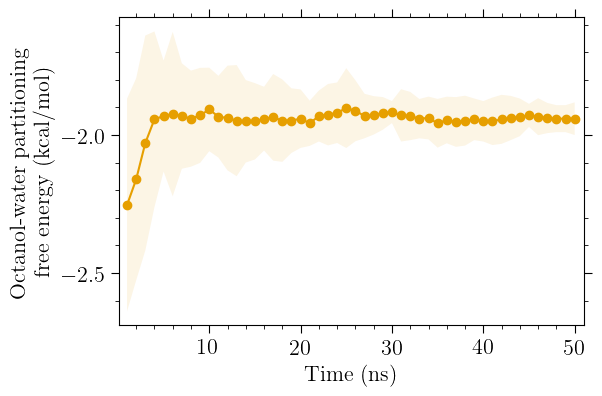

In [12]:
%cd -q $homedir

fig, ax = plt.subplots(figsize=(6,4))

dG_water = np.zeros(50)
dG_water_err = np.zeros(50)
dG_octanol = np.zeros(50)
dG_octanol_err = np.zeros(50)

for i in range(50):
    # Water
    with open('Simulations/BAR/Water/BAR_result/bar_{}.out'.format((i+1)*1000), 'r') as f:
        lines = f.readlines()
    f.close()
    dG_water[i] = float(lines[-2].split()[5]) * kJ_to_kcal
    dG_water_err[i] = float(lines[-2].split()[7]) * kJ_to_kcal * 1.96 # 95% errors.
                         

    # Octanol
    with open('Simulations/BAR/1-Octanol/BAR_result/bar_{}.out'.format((i+1)*1000), 'r') as f:
        lines = f.readlines()
    f.close()
    dG_octanol[i] = float(lines[-2].split()[5]) * kJ_to_kcal
    dG_octanol_err[i] = float(lines[-2].split()[7]) * kJ_to_kcal * 1.96 # 95% errors.

dG_water = unumpy.uarray(dG_water, dG_water_err)
dG_octanol = unumpy.uarray(dG_octanol, dG_octanol_err)
ddG = dG_octanol - dG_water

ax.plot(range(1,51), unumpy.nominal_values(ddG), marker='o')
ax.fill_between(range(1,51), y1=unumpy.nominal_values(ddG)-unumpy.std_devs(ddG),
                y2=unumpy.nominal_values(ddG)+unumpy.std_devs(ddG), alpha=0.1)


ax.set_xlim(0.1, 51)
ax.set_xlabel('Time (ns)', fontsize=16)
ax.set_ylabel(f'Octanol-water partitioning\nfree energy (kcal/mol)', fontsize=16)
ax.minorticks_on()
ax.locator_params(axis='y', nbins=4)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(axis='both', which='major', labelsize=16, length=6)
ax.tick_params(axis='both', which='minor', labelsize=16, length=3)

fig.savefig('Figures/Flexible_BAR_convergence.pdf', bbox_inches='tight')

## Step 6: Evaluation of *n*-hexanol Structural Ensemble During the Alchemical Transformation

In [13]:
%cd -q $homedir

# Octanol
traj_lambda_0 = md.load('Simulations/BAR/1-Octanol/1/BAR.xtc',
                        top='Simulations/BAR/1-Octanol/1/BAR.gro')
traj_lambda_1 = md.load('Simulations/BAR/1-Octanol/10/BAR.xtc',
                        top='Simulations/BAR/1-Octanol/10/BAR.gro')
traj_lambda_2 = md.load('Simulations/BAR/1-Octanol/15/BAR.xtc',
                        top='Simulations/BAR/1-Octanol/15/BAR.gro')
# Water
traj_lambda_3 = md.load('Simulations/BAR/Water/1/BAR.xtc',
                        top='Simulations/BAR/Water/1/BAR.gro')
traj_lambda_4 = md.load('Simulations/BAR/Water/10/BAR.xtc',
                        top='Simulations/BAR/Water/10/BAR.gro')
traj_lambda_5 = md.load('Simulations/BAR/Water/15/BAR.xtc',
                        top='Simulations/BAR/Water/15/BAR.gro')

hexanol_indices = traj_lambda_0.topology.select('resname "HEX"')

for traj in [traj_lambda_0, traj_lambda_1, traj_lambda_2, traj_lambda_3, traj_lambda_4, traj_lambda_5]:
    traj.atom_slice(hexanol_indices, inplace=True)

### Principal Component Analysis Based on Heavy Atom Distances

/tmp/ipykernel_43982/257037203.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(h_pad=5, w_pad=3)


Explained variance by PC1: 23.99%
Explained variance by PC2: 13.99%


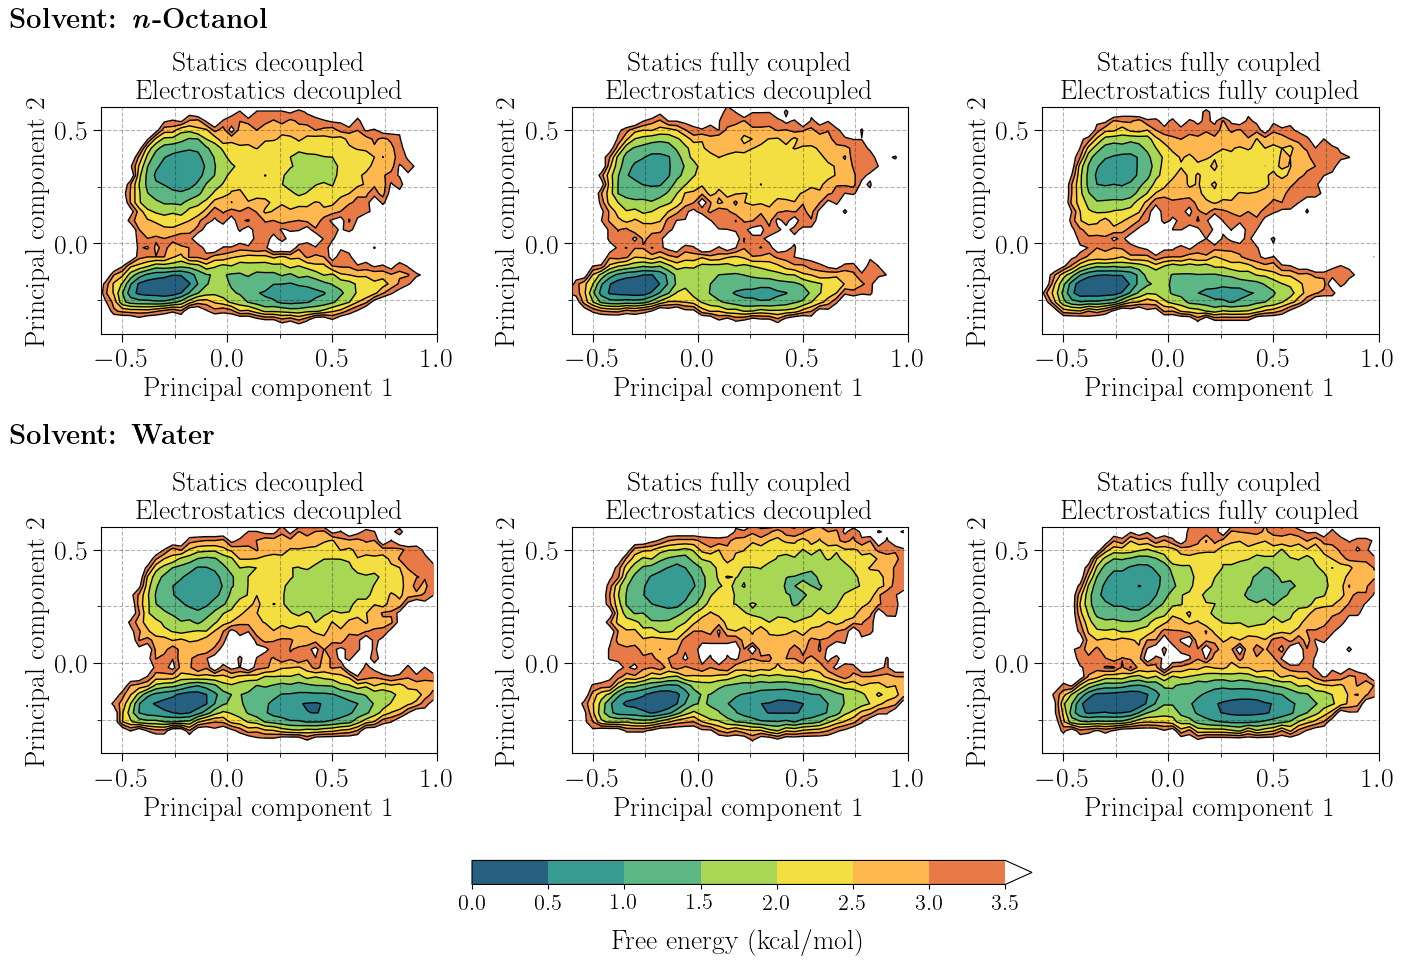

In [14]:
heavy_atom_pairs = traj_lambda_0.topology.select_pairs('not element hydrogen', 'not element hydrogen')
pairwise_distances = md.geometry.compute_distances(traj_lambda_0+traj_lambda_1+traj_lambda_2+traj_lambda_3+traj_lambda_4+traj_lambda_5, heavy_atom_pairs)

pca = PCA(n_components=2)
reduced_distances = pca.fit_transform(pairwise_distances)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14,8))

label = 2*[f'Statics decoupled\nElectrostatics decoupled',
           f'Statics fully coupled\nElectrostatics decoupled',
           f'Statics fully coupled\nElectrostatics fully coupled']

for i, ax in enumerate(axes.flatten()):
    j = i * traj_lambda_0.n_frames
    k = j + traj_lambda_0.n_frames
    free_energies = get_2D_PMF(reduced_distances[j:k, 0],
                               reduced_distances[j:k, 1],
                               nbins=50, ranges=((-1, 1), (-1, 1)), kT=0.5925)
    lines = ax.contour(free_energies[0], free_energies[1], free_energies[2], levels=np.arange(0,4.0,0.5), linewidths=1, colors='k')
    fill = ax.contourf(free_energies[0], free_energies[1], free_energies[2], cmap='fessa', extend='max', levels=np.arange(0,4.0,0.5))
    cmap = fill.get_cmap()
    cmap.set_over('white')
    fill.set_cmap(cmap)
    ax.minorticks_on()
    ax.set_title(label[i], fontsize=20)
    ax.set_xlabel('Principal component 1', fontsize=20)
    ax.set_ylabel('Principal component 2', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20, length=6)
    ax.tick_params(axis='both', which='minor', labelsize=20, length=3)
    ax.set_xticks(ticks=[-0.5, 0.0, 0.5, 1.0], minor=False)
    ax.set_xticks(ticks=[-0.25, 0.25, 0.75], minor=True)
    ax.set_yticks(ticks=[-0.5, 0.0, 0.5], minor=False)
    ax.set_yticks(ticks=[-0.75, -0.25, 0.25, 0.75], minor=True)
    ax.grid(linestyle='--', color='black', alpha=0.3, which='both')
    ax.set_xlim(-0.6, 1.0)
    ax.set_ylim(-0.4, 0.6)
    
cbar_ax = fig.add_axes([0.33, -0.06, 0.4, 0.03])
cbar = fig.colorbar(fill, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_title('Free energy (kcal/mol)', y=-3, fontsize=20, loc='center')
    
fig.tight_layout(h_pad=5, w_pad=3)

fig.text(0, 1.01, r'$\textbf{Solvent: \textit{n}-Octanol}$', fontsize=20, fontweight='bold')
fig.text(0, 0.49, r'$\textbf{Solvent: Water}$', fontsize=20, fontweight='bold')

print('Explained variance by PC1: {:.2f}%'.format(pca.explained_variance_ratio_[0]*100))
print('Explained variance by PC2: {:.2f}%'.format(pca.explained_variance_ratio_[1]*100))
fig.savefig('Figures/Flexible_BAR_PCA_space.pdf', bbox_inches='tight')